In this notebook, we're going to create a Deep Convolutional GAN (DCGAN) using layers of Convolutional Neural Network (CNN) on MNIST dataset. This is an implimentation from this paper:
https://arxiv.org/pdf/1511.06434v1.pdf

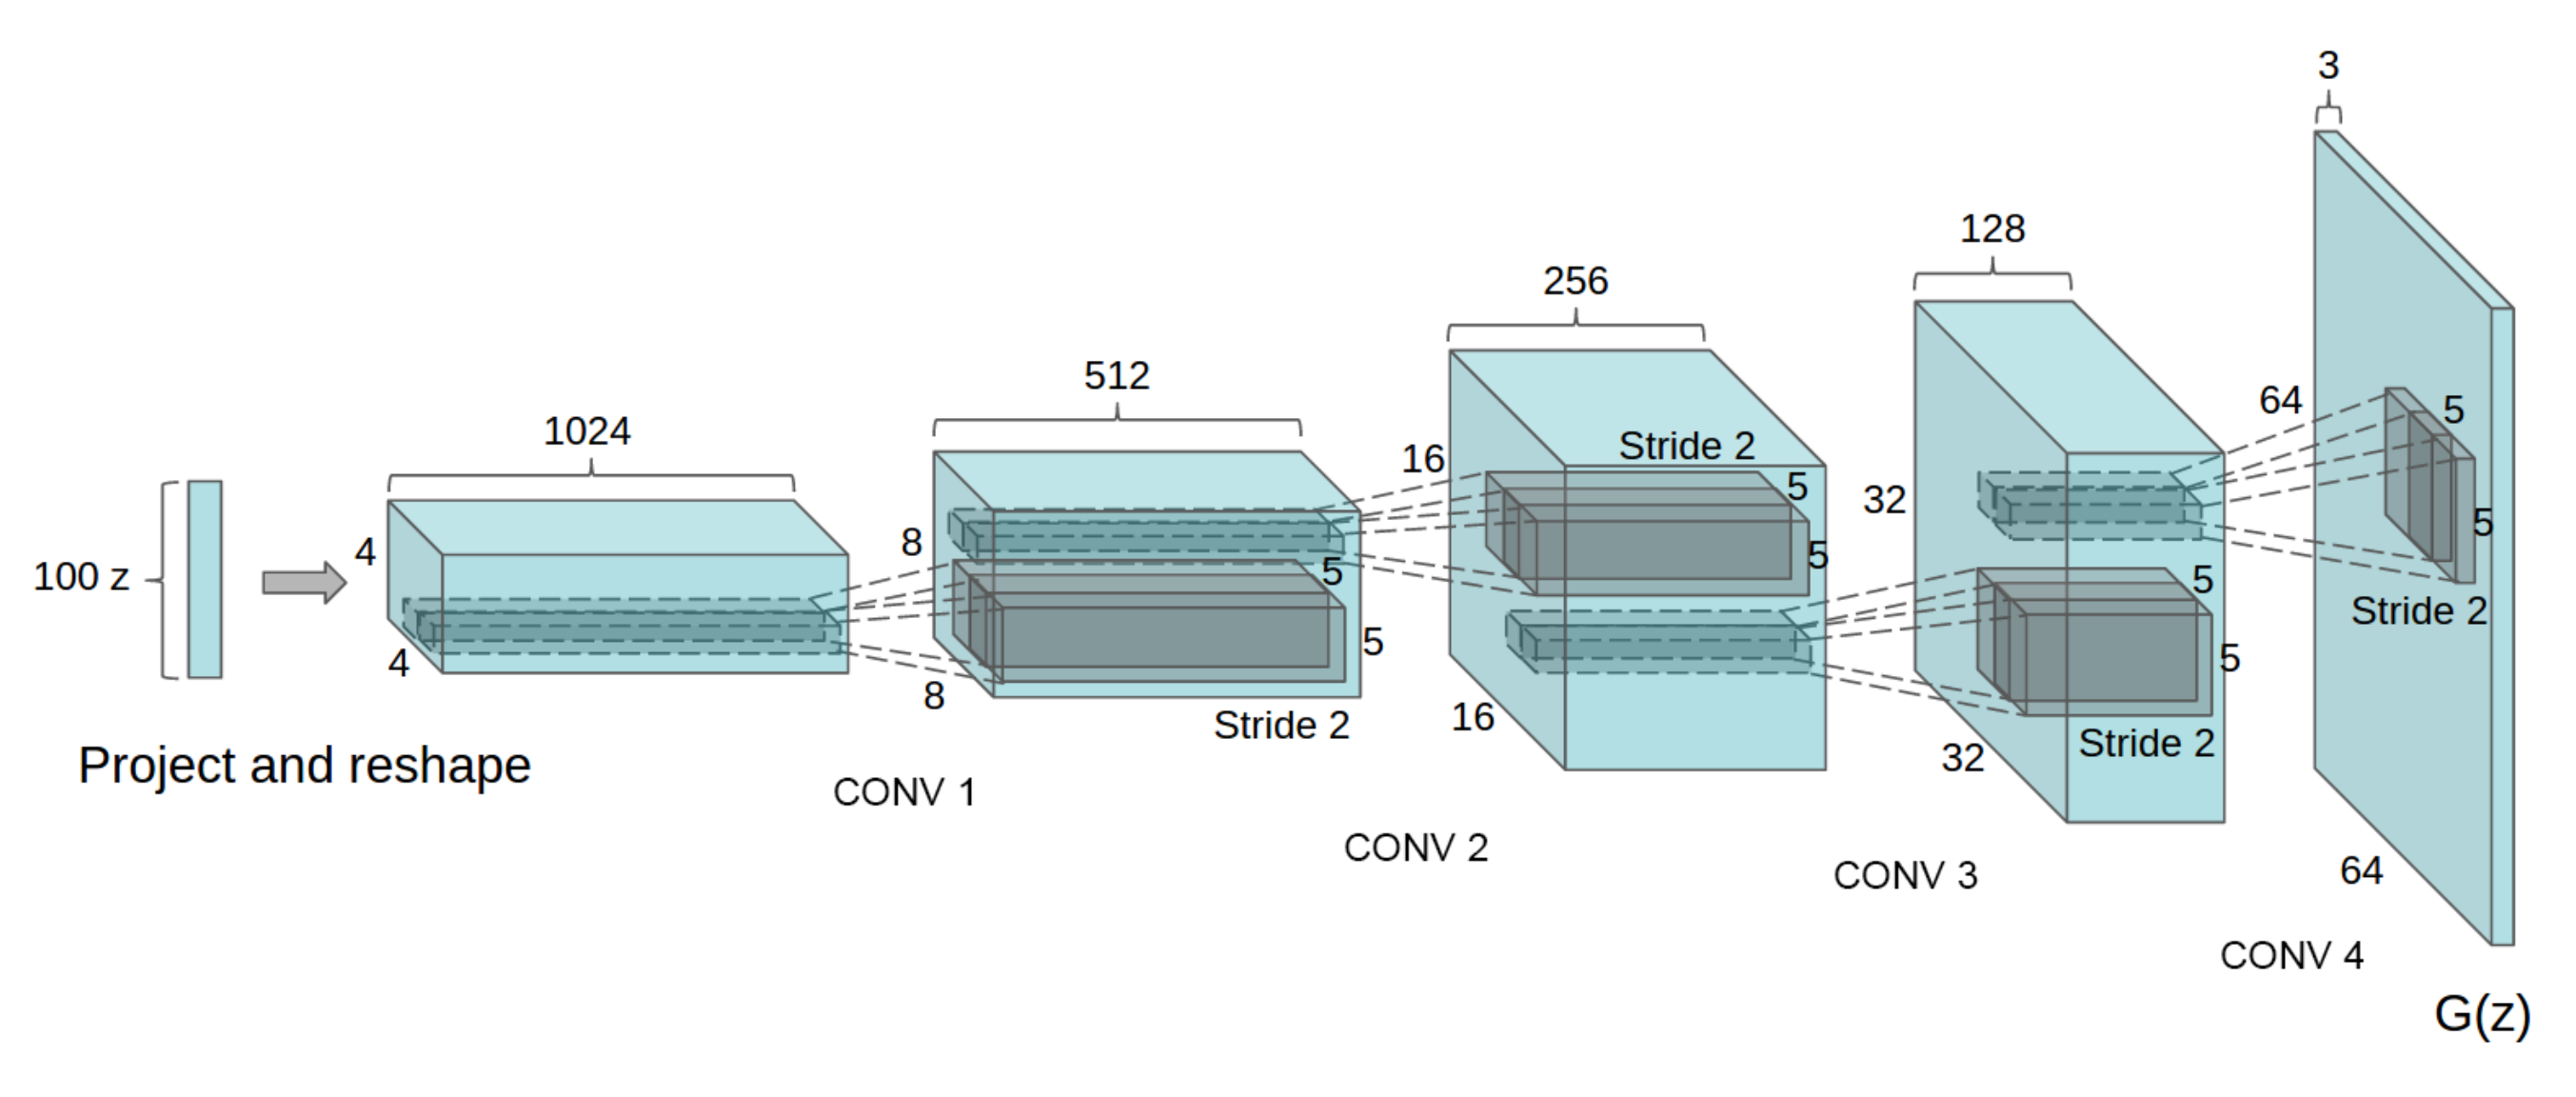
Figure: Architectural drawing of a generator from DCGAN from Radford et al (2016).

## DCGAN

Here are main features of DCGAN:
* Use convolutions without any pooling layers, but with strided convolutions. This allows the network to learn its own spatial downsampling. This approach is used in the Generator that allows it to learn its own spatial upsampling, and Discriminator.
* Use Batch Normalization in both the Generator and the Discriminator. This helps stabilize learning by normalizing the input to each unit to have zero mean and unit variance. This also helps deal with training problems that arise due to poor initialization and helps gradients flow in deeper models. But applying bathnorms to all layers resulted in sample oscillation and model instability. To avoid this we don't apply batchnorms to the output layers of the Generator and Discriminator.
* Don't use fully connected hidden layers.
* Use ReLU activation function in the Generator for all layers except for the output, which uses a Tanh activation.
* Use LeakyReLU activation in the Discriminator for all layers except for the output, which does not sue an activation.

We begin by importing some useful packeages and data and a helper function, which helps see the images GAN will create.

In [15]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator

The first component is the Generator. Instead of passing the image dimention, we'll pass the number of image channels to the generator (in our case is 1 - MNIST is black and white image dataset). Because with DCGAN, convolutions don't depend on the number of pixels on an image. However, the number of channels is important to determine the size of the learnable filters.

Let's begin create the Generator with 4 layers (3 hidden layers + 1 output layer). 

At the end of the Generator class, a forward pass function takes a noise vector and generates an image of the output dimention.

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the NN
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
    
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
          Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: # Final layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.Tanh()
            )
    
    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)
    
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [13]:
def get_noise(n_samples, z_dim, device='cpu'):
        '''
        Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
        creates a tensor of that shape filled with random numbers from the normal distribution.
        Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
        '''
        return torch.randn(n_samples, z_dim, device=device)

## Discriminator

The second component is Discriminator. Let's use 3 layers in the Discriminator's neural network.

In [10]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )
        
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2)
            )
        else: # Final layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
            )
    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Training

Now we can put it all together! Let's begin with tunable parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type

In addition, be warned that **this runs very slowly on the default CPU**. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab, click on `Runtime -> Change runtime type` and set hardware accelerator to GPU and replace
`device = "cpu"`
with
`device = "cuda"`. The code should then run without any more changes, over 1,000 times faster.

In [6]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# We can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



The next step is to initialize the generator, discriminator and optimizers

In [11]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# Initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Now we can train GAN! For each epoch, we'll process the entire dataset in batches, and for every batch, we'll update the discriminator and generator, then we can the DCGAN's results.

Here's roughly the progression you should be expecting. On GPU this takes about 30 seconds per thousand steps. On CPU, this can take about 8 hours per thousand steps. Notice that in the image of Step 5000, the generator is disproprotionately producing things that look like ones. If the discriminator didn't learn to detect this imbalance quickly enough, then the generator could just produce more ones. As a result, it may have ended up tricking the discriminator so well that there would be no more improvement, known as **mode collapse**:
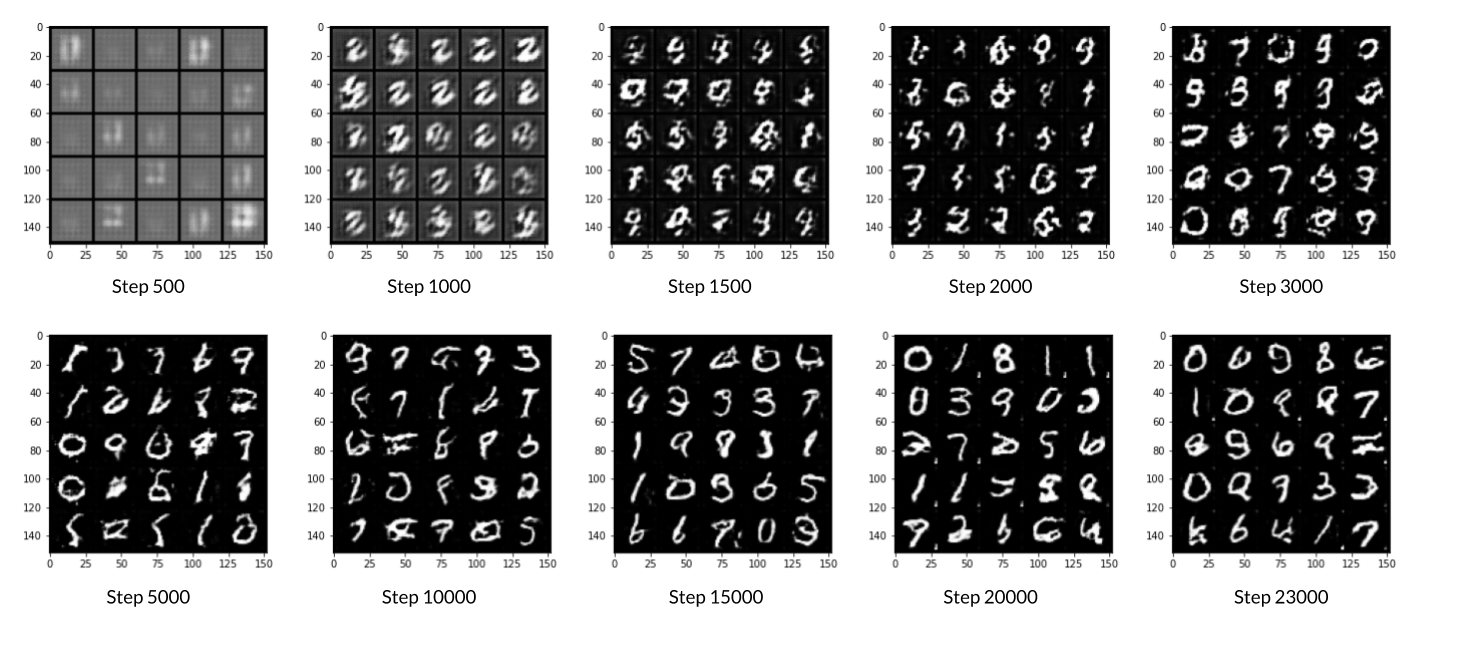

Epoch 1, step 500: Generator loss: 2.0834635580778116, discriminator loss: 0.1777129421681163


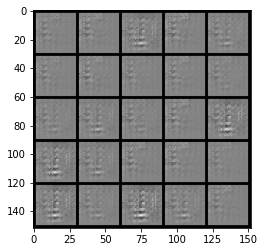

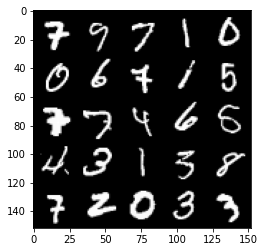

Epoch 2, step 1000: Generator loss: 2.2882543339729313, discriminator loss: 0.26656393386423594


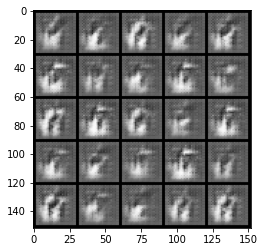

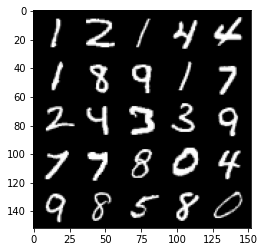

Epoch 3, step 1500: Generator loss: 1.4641291156709186, discriminator loss: 0.4290286764204506


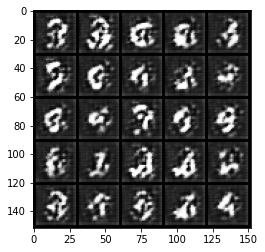

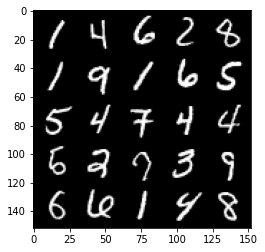

Epoch 4, step 2000: Generator loss: 1.0694141632914542, discriminator loss: 0.5305247576832773


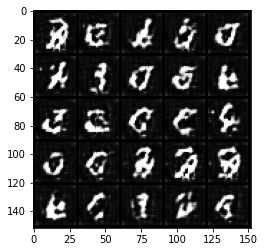

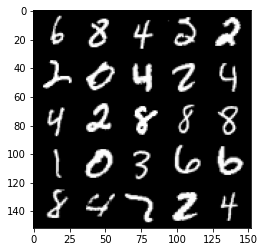

Epoch 5, step 2500: Generator loss: 0.9333717345595357, discriminator loss: 0.5791809037327768


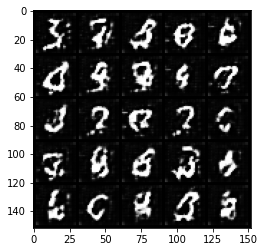

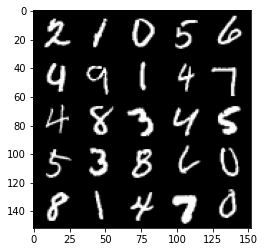

Epoch 6, step 3000: Generator loss: 0.8604374928474432, discriminator loss: 0.6148248759508131


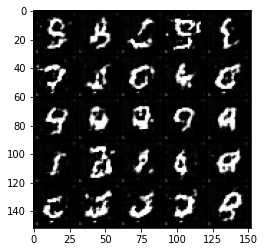

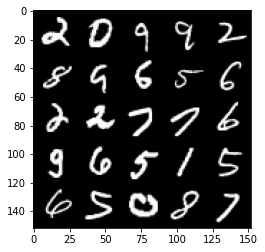

Epoch 7, step 3500: Generator loss: 0.8230189828872689, discriminator loss: 0.6374578169584271


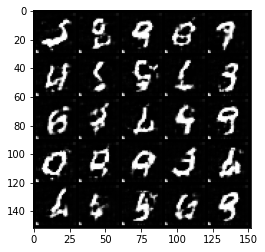

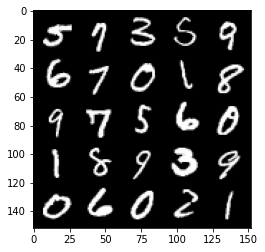

Epoch 8, step 4000: Generator loss: 0.7955329574346548, discriminator loss: 0.651102710008621


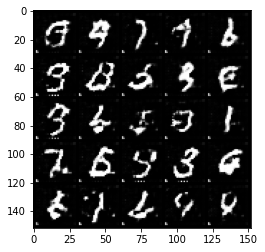

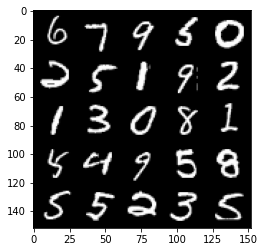

Epoch 9, step 4500: Generator loss: 0.7945106203556052, discriminator loss: 0.6539412699937822


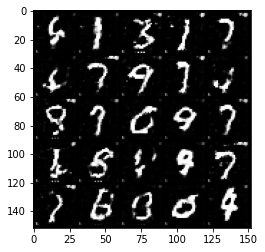

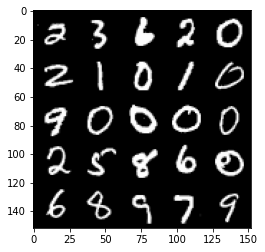

Epoch 10, step 5000: Generator loss: 0.7911048033833515, discriminator loss: 0.6606722333431246


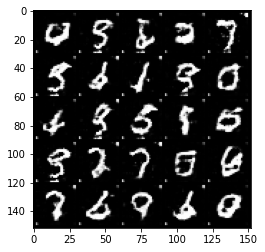

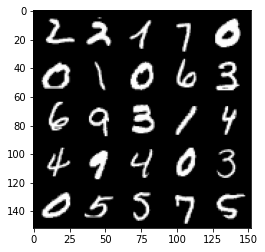

Epoch 11, step 5500: Generator loss: 0.7776712386012078, discriminator loss: 0.6645978296995162


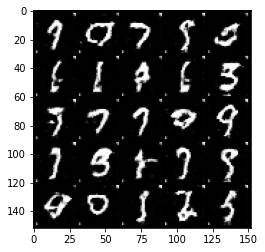

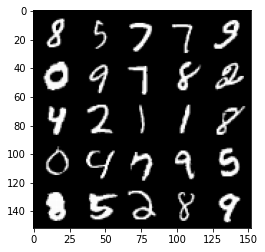

Epoch 12, step 6000: Generator loss: 0.7694363112449637, discriminator loss: 0.6681977514028552


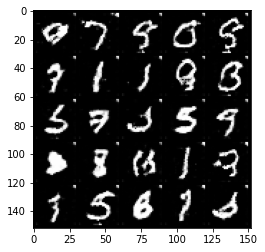

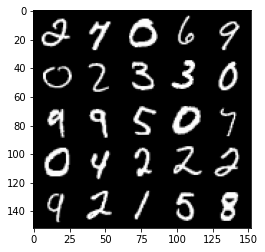

Epoch 13, step 6500: Generator loss: 0.7567238873243329, discriminator loss: 0.6705305224657059


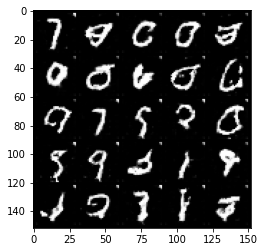

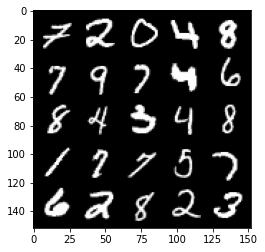

Epoch 14, step 7000: Generator loss: 0.7527846568226817, discriminator loss: 0.6763833438158031


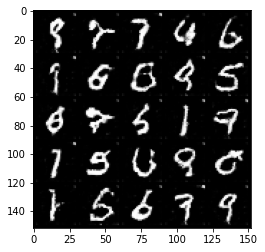

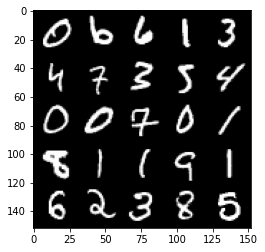

Epoch 15, step 7500: Generator loss: 0.7475084669589999, discriminator loss: 0.6808201336860658


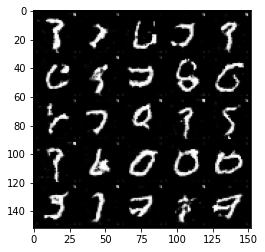

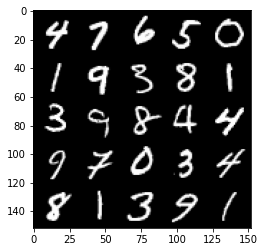

Epoch 17, step 8000: Generator loss: 0.737118130922317, discriminator loss: 0.6840385764837267


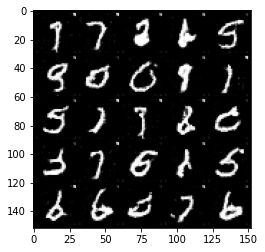

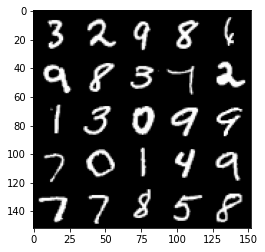

Epoch 18, step 8500: Generator loss: 0.7301814885139466, discriminator loss: 0.6884807870388034


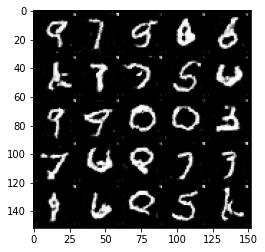

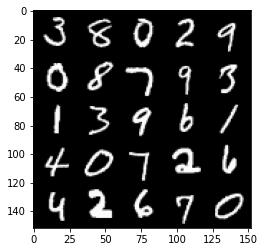

Epoch 19, step 9000: Generator loss: 0.7270476616621022, discriminator loss: 0.6912770501375197


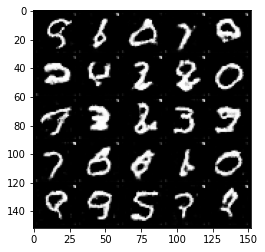

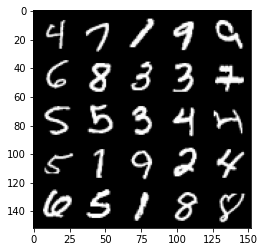

Epoch 20, step 9500: Generator loss: 0.7213686639070512, discriminator loss: 0.6938735486268992


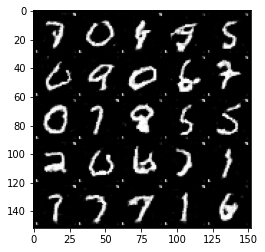

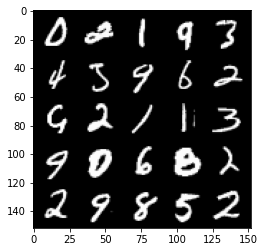

Epoch 21, step 10000: Generator loss: 0.7166109540462496, discriminator loss: 0.6959047056436547


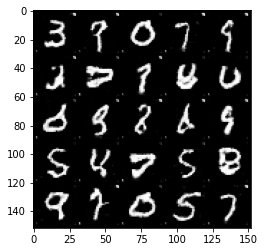

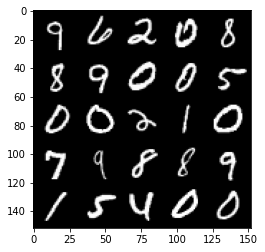

Epoch 22, step 10500: Generator loss: 0.7161379234790802, discriminator loss: 0.6965226805210116


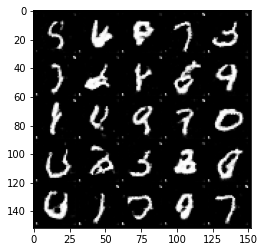

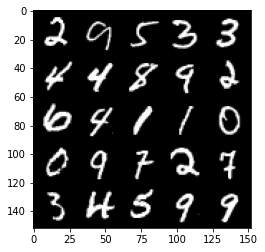

Epoch 23, step 11000: Generator loss: 0.7117141219377509, discriminator loss: 0.6982422487735747


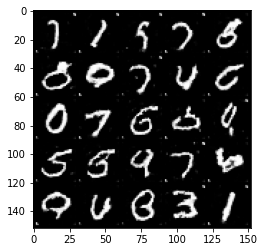

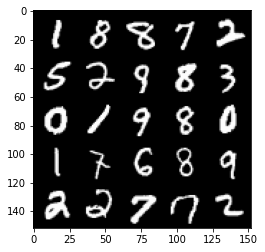

Epoch 24, step 11500: Generator loss: 0.7132086351513869, discriminator loss: 0.6986665024757377


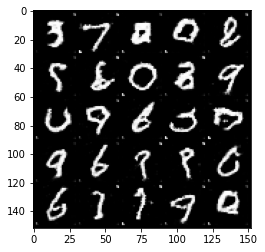

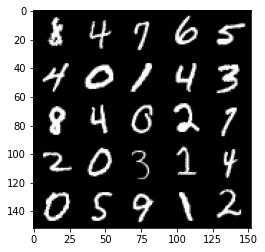

Epoch 25, step 12000: Generator loss: 0.7110481619238854, discriminator loss: 0.6999616402387618


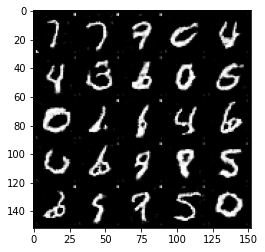

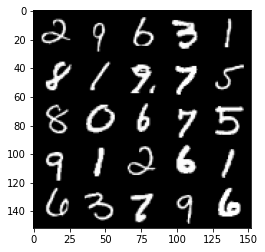

Epoch 26, step 12500: Generator loss: 0.7057638190388678, discriminator loss: 0.7007386524677269


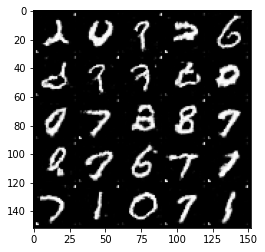

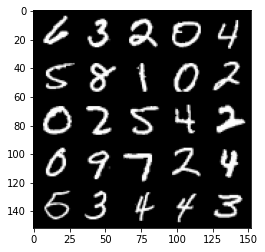

Epoch 27, step 13000: Generator loss: 0.7078913367986676, discriminator loss: 0.6979488272666926


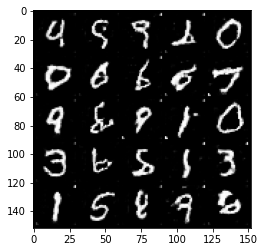

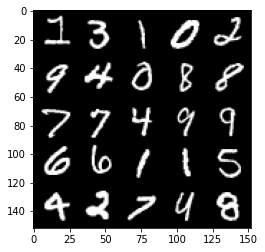

Epoch 28, step 13500: Generator loss: 0.7071673289537431, discriminator loss: 0.6984113013744352


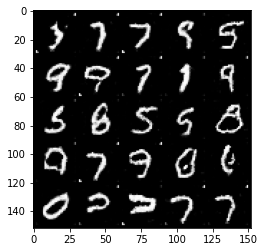

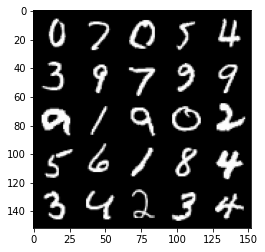

Epoch 29, step 14000: Generator loss: 0.7076701462864868, discriminator loss: 0.6979875166416173


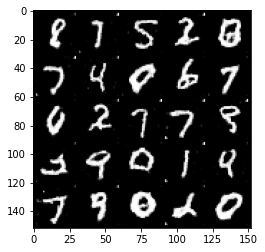

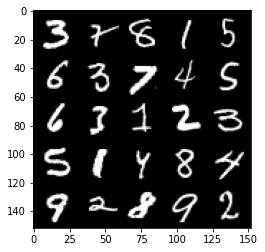

Epoch 30, step 14500: Generator loss: 0.7107953708171847, discriminator loss: 0.6970245029926304


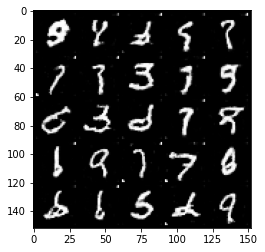

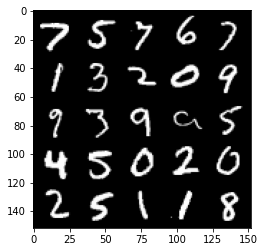

Epoch 31, step 15000: Generator loss: 0.7067187914252285, discriminator loss: 0.6978605188131328


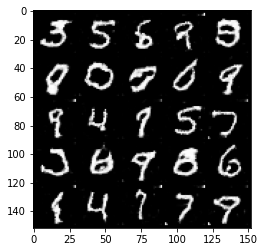

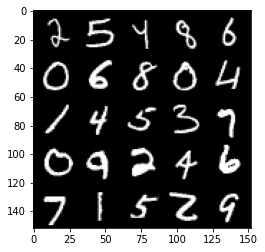

Epoch 33, step 15500: Generator loss: 0.7037331070899973, discriminator loss: 0.6977263363599775


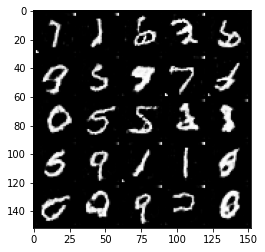

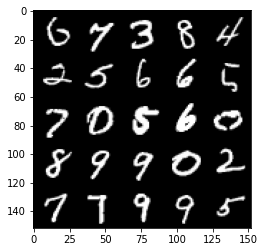

Epoch 34, step 16000: Generator loss: 0.7046864607334136, discriminator loss: 0.6971392257213592


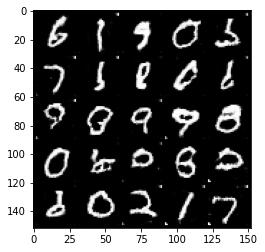

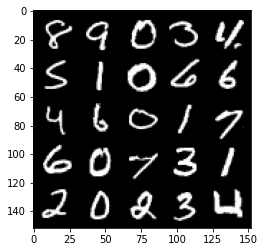

Epoch 35, step 16500: Generator loss: 0.706038552761078, discriminator loss: 0.697526645421982


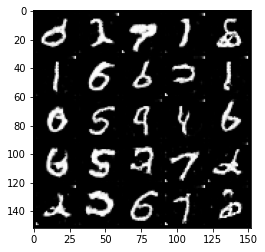

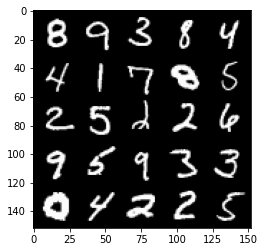

Epoch 36, step 17000: Generator loss: 0.6993436204195024, discriminator loss: 0.6988625669479368


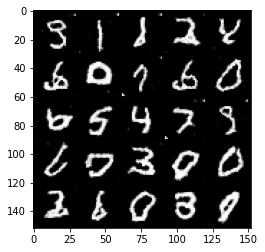

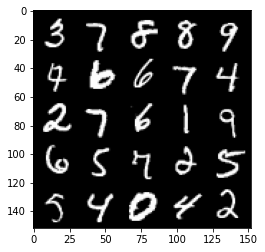

Epoch 37, step 17500: Generator loss: 0.7021458581686024, discriminator loss: 0.6979689104557039


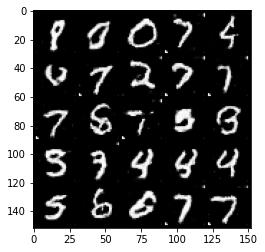

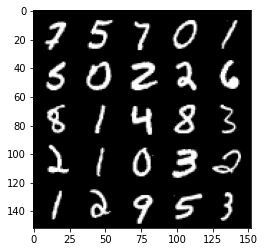

Epoch 38, step 18000: Generator loss: 0.7005822693109512, discriminator loss: 0.6964910031557083


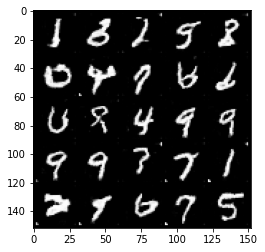

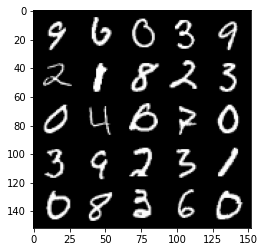

Epoch 39, step 18500: Generator loss: 0.7039754526019092, discriminator loss: 0.6964296940565107


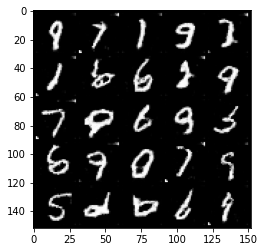

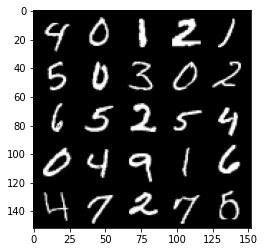

Epoch 40, step 19000: Generator loss: 0.7025253862142559, discriminator loss: 0.6964734810590745


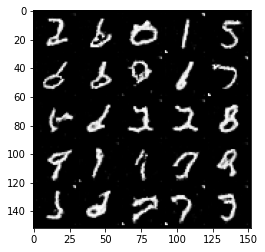

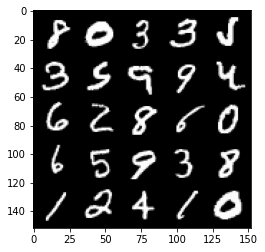

Epoch 41, step 19500: Generator loss: 0.7011592079401012, discriminator loss: 0.6969270477294922


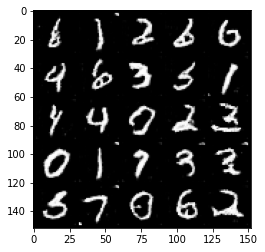

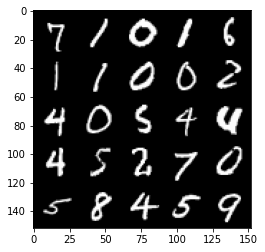

Epoch 42, step 20000: Generator loss: 0.7010424669384961, discriminator loss: 0.6962246367931366


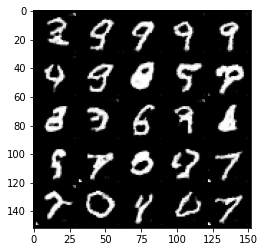

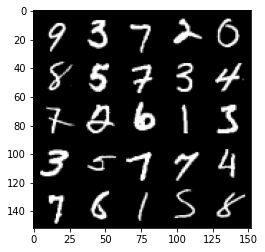

Epoch 43, step 20500: Generator loss: 0.7003359771966935, discriminator loss: 0.6969592490196223


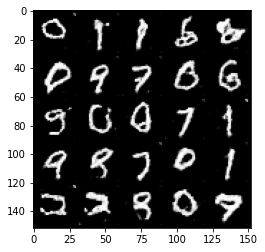

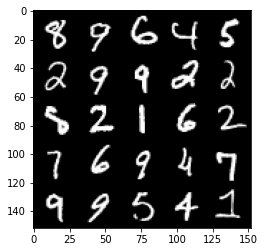

Epoch 44, step 21000: Generator loss: 0.6989513391256332, discriminator loss: 0.6958990859985354


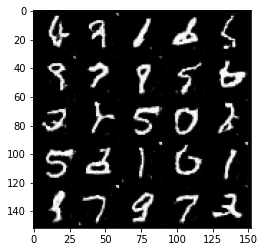

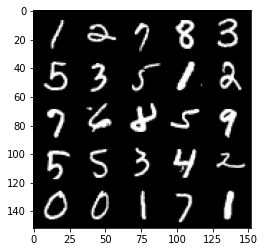

Epoch 45, step 21500: Generator loss: 0.6985918372869494, discriminator loss: 0.6976348351240166


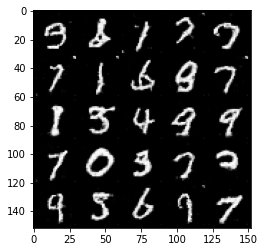

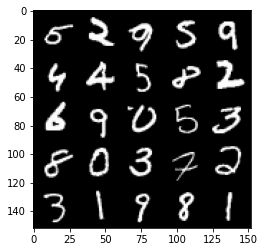

Epoch 46, step 22000: Generator loss: 0.6943739815950389, discriminator loss: 0.6974027287960048


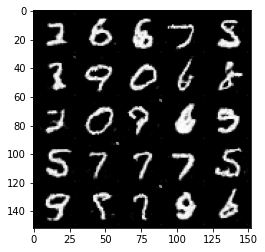

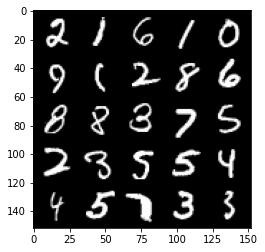

Epoch 47, step 22500: Generator loss: 0.6956611455678947, discriminator loss: 0.6968950630426406


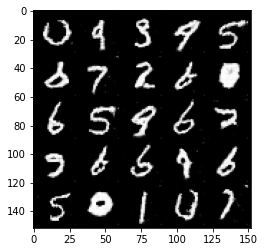

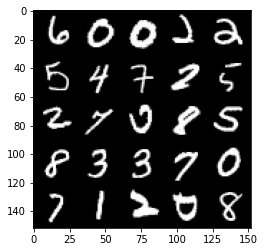

Epoch 49, step 23000: Generator loss: 0.7003278462886805, discriminator loss: 0.6957306711673734


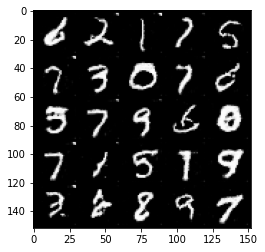

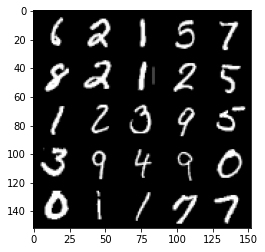

In [16]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)
        
        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()
        
         ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1